In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import tensorflow as tf


In [2]:
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [3]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [4]:
inpDir='../input'
outDir='../output'
subDir='fashion_MNIST'
logDir='../log'
modelDir='../models'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 10 # number of epochs

ALPHA = 0.001 # learning rate

BATCH_SIZE=32
PATIENCE=10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (9, 9),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [5]:
train_df = pd.read_csv("fashion-mnist_train.csv",header=0)
test_df = pd.read_csv("fashion-mnist_test.csv",header=0)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
class_names = {0 : 'T-shirt/top',
          1 : 'Trouser',
          2 : 'Pullover',
          3 : 'Dress',
          4 : 'Coat',
          5 : 'Sandal',
          6 : 'Shirt',
          7 : 'Sneaker',
          8 : 'Bag',
          9 : 'Ankle boot'
          }

In [7]:
def split_feature_label(row):
    
    feature = tf.reshape(row[1:], [28,28,1])
    label = row[0]
    return feature , label

In [8]:
temp_ds= tf.data.Dataset.from_tensor_slices(train_df)

train_ds= temp_ds.map(split_feature_label)

train_ds= train_ds.batch(BATCH_SIZE)

# Whats in the Data?

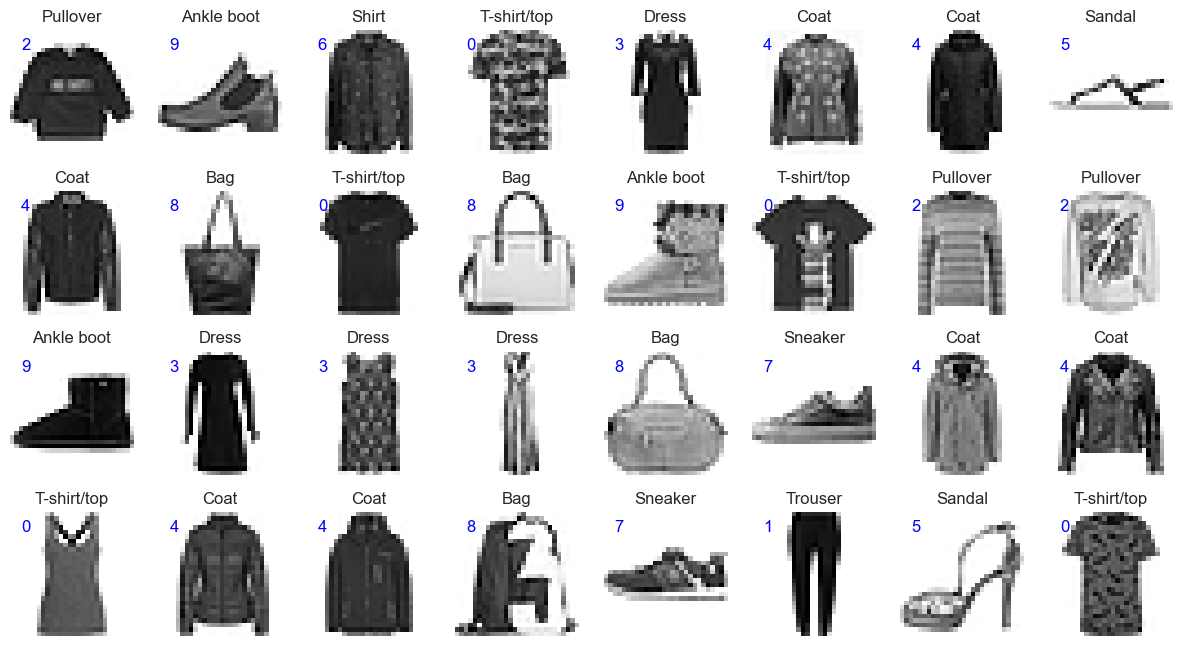

In [9]:
#Sample Data ploy
fig= plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)
        
        plt.imshow(images[i].numpy().astype('uint16'), cmap= plt.cm.binary, interpolation='nearest')
        
        plt.title(class_names[labels[i].numpy()])
        
        plt.text(2,4,labels[i].numpy(),color='b',fontsize=12)
        
        plt.axis('off')
plt.show()

In [10]:
tmp_ds= tf.data.Dataset.from_tensor_slices(test_df)

test_ds= tmp_ds.map(split_feature_label)

test_ds= test_ds.batch(BATCH_SIZE)

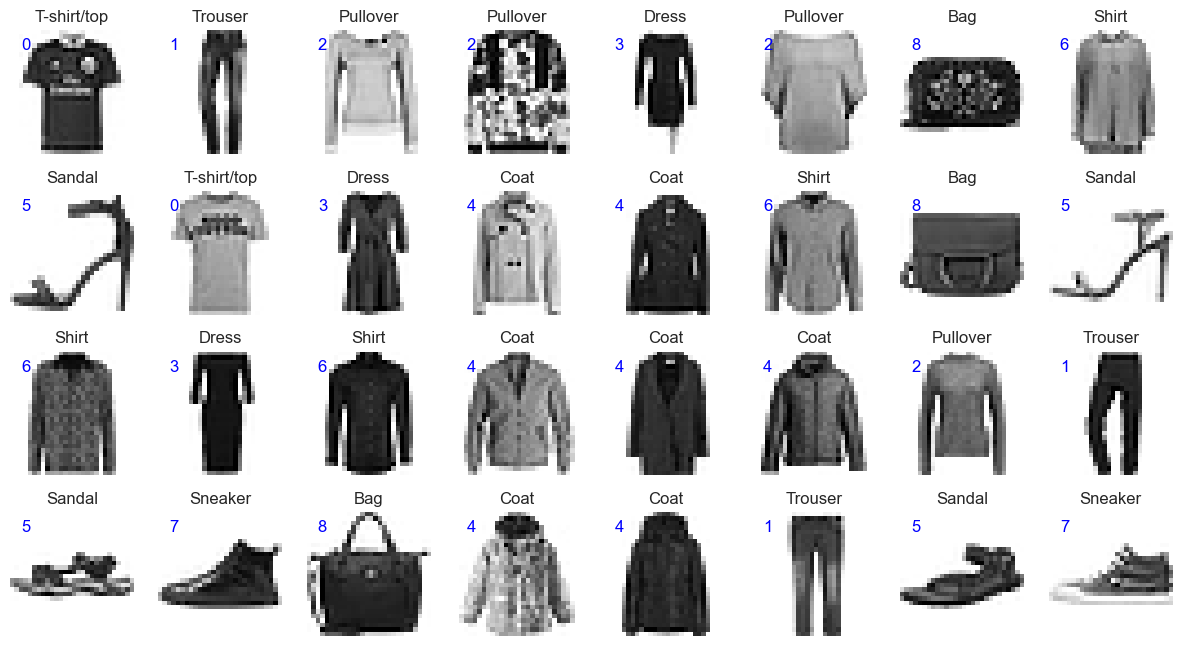

In [11]:

fig= plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)
        
        plt.imshow(images[i].numpy().astype('uint16'), cmap= plt.cm.binary, interpolation='nearest')
        
        plt.title(class_names[labels[i].numpy()])
        
        plt.text(2,4,labels[i].numpy(),color='b',fontsize=12)
        
        plt.axis('off')
plt.show()

In [12]:
#Optimize for performance
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds= test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# In subsequent copies, delete these lines

In [13]:
norm_layer= tf.keras.layers.Rescaling(1./225.)  #rescaling layer

images, labels= next(iter(train_ds)) #one batch

img= images[0].numpy()

print(img.max(), img.min())
#-------------------------
norm_ds= train_ds.map(lambda x, y: (norm_layer(x),y))

images, labels= next(iter(norm_ds))

img= images[0].numpy()

print(img.max(), img.min())


255 0
1.1333333 0.0


# Convolution Layer

In [14]:
input_shape= (1,6,6,1)  #batch x h x w x c

X=tf.random.normal(input_shape)

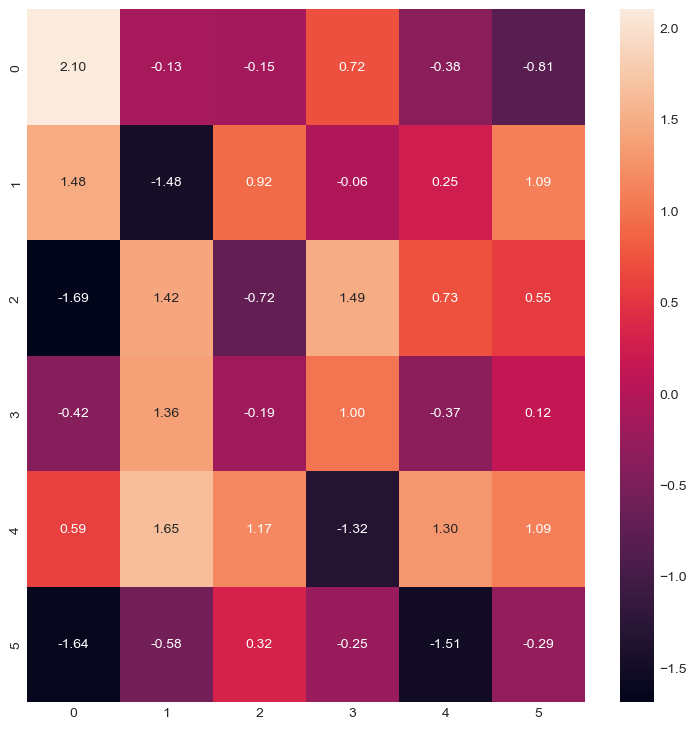

In [15]:
sns.heatmap(X.numpy()[0, :, :,0],annot=True,fmt='.2f');

In [16]:
y=tf.keras.layers.Conv2D(1,3,
                         kernel_initializer=tf.constant_initializer(1.),
                        activation='relu',
                        use_bias=False,
                        input_shape=input_shape[1:])(X)
y.shape

TensorShape([1, 4, 4, 1])

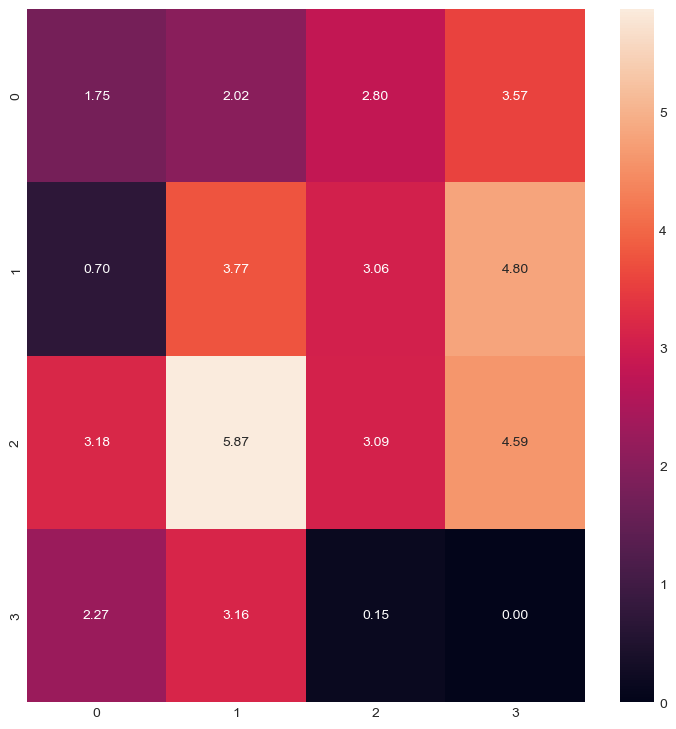

In [17]:
sns.heatmap(y.numpy()[0, :, :,0],annot=True,fmt='.2f');

In [18]:
max_pool_layer= tf.keras.layers.MaxPool2D(pool_size=(2,2), 
                                          strides=(2,2),
                                          padding='valid')
z=max_pool_layer(y)

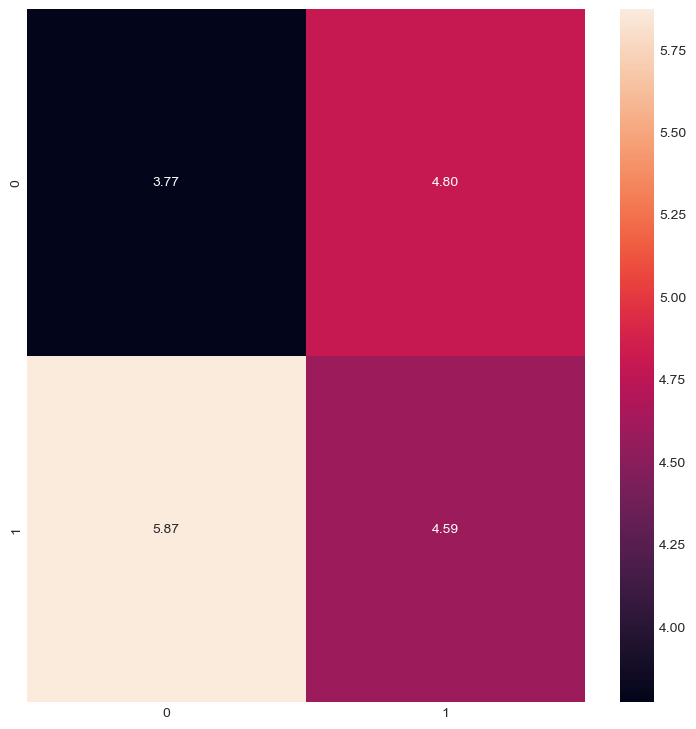

In [19]:
sns.heatmap(z.numpy()[0, :, :,0],annot=True,fmt='.2f');

# Prepare Model

Due to overfitting we will do regularization

In [25]:
reg_lambda=0.005
knl_reg= tf.keras.regularizers.L2(reg_lambda)

model= tf.keras.Sequential()

#Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

#Set 1
model.add(tf.keras.layers.Conv2D(32,3,
    padding='same',
    activation='relu',
    kernel_regularizer=knl_reg,
    input_shape=(28,28,1)   #o/p--> 28 x 28 x 32
))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p---> 14 x 14 x 32


#Set 2
model.add(tf.keras.layers.Conv2D(64,3,
    activation='relu',
    kernel_regularizer=knl_reg))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #o/p---> 6 x 6 x 64


#Set 3
model.add(tf.keras.layers.Conv2D(128,3,
    activation='relu',
    kernel_regularizer=knl_reg))#o/p---> 4 x 4 x 128

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

# Head Part

In [26]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64,activation= 'relu', kernel_regularizer=knl_reg))

model.add(tf.keras.layers.Dense(10))

In [28]:
model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [29]:
#Model callback
checkpoint_path=os.path.join(modelDir,subDir,'Fashion_cnn')

model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

#EarlyStopping callback
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    restore_best_weights=True
)


In [30]:
history= model.fit(train_ds,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   callbacks=[model_checkpoint_callback,
                              es_callback],
                   validation_data=test_ds)

Epoch 1/10


1873/1875 [============================>.] - ETA: 0s - loss: 0.8677 - accuracy: 0.7918
Epoch 1: val_loss improved from inf to 0.66137, saving model to ../models\fashion_MNIST\Fashion_cnn
1875/1875 [==============================] - 21s 10ms/step - loss: 0.8675 - accuracy: 0.7918 - val_loss: 0.6614 - val_accuracy: 0.8449
Epoch 2/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6405 - accuracy: 0.8412
Epoch 2: val_loss improved from 0.66137 to 0.59990, saving model to ../models\fashion_MNIST\Fashion_cnn
1875/1875 [==============================] - 18s 10ms/step - loss: 0.6405 - accuracy: 0.8411 - val_loss: 0.5999 - val_accuracy: 0.8533
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.8506
Epoch 3: val_loss improved from 0.59990 to 0.57563, saving model to ../models\fashion_MNIST\Fashion_cnn
1875/1875 [==============================] - 18s 10ms/step - loss: 0.5944 - accuracy: 0.8506 - val_loss: 0.5756 - val_accuracy

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)        

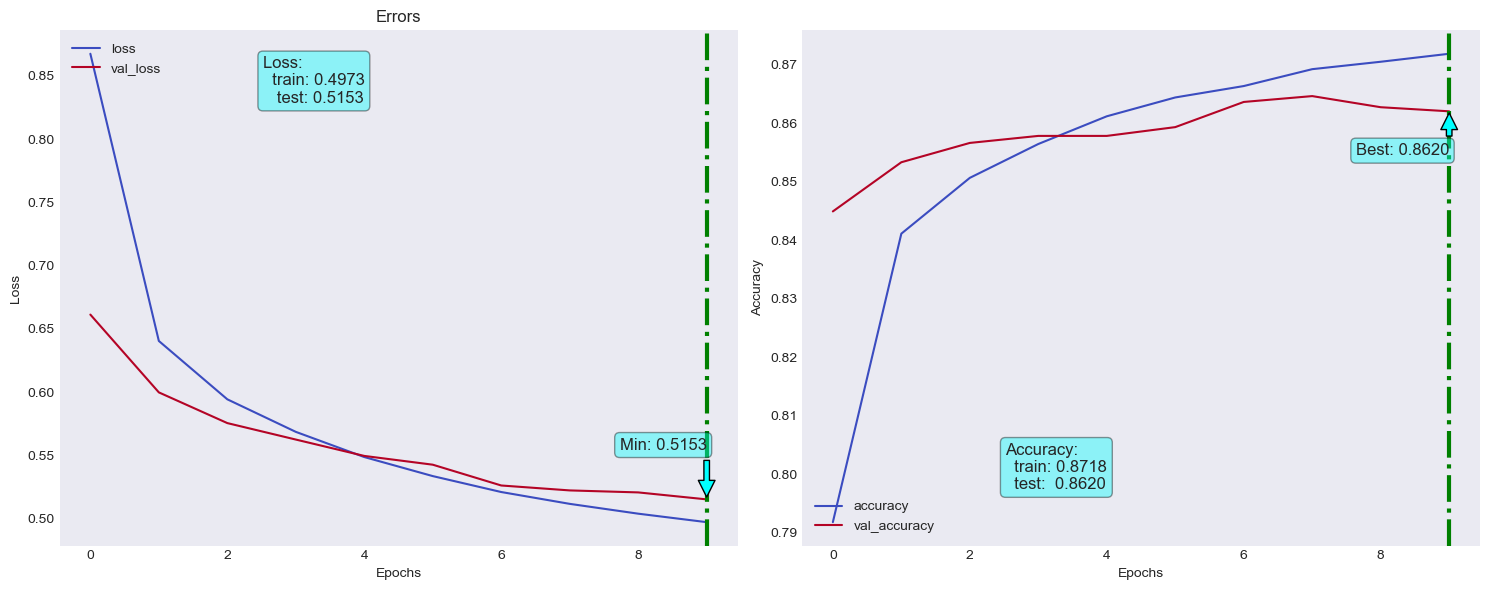

In [32]:
fn_plot_tf_hist(pd.DataFrame(history.history))